# Методы машинного обучения в предсказании ВР

## Общие соображене

Часто  при построении моделей прогназирования ВР приходится руководствоваться принципом скорости. При этом основными __недостатками__ моделей [`SARIMA`](https://sherbold.github.io/intro-to-data-science/09_Time-Series-Analysis.html) являются :
* сложность предварительного анализа и подготовки данных. 
* необходимость частого переобучения. 
* трудно настраиваемы параметры моделей. 
Поэтому [__зачастую гораздо проще__](https://mlcourse.ai/book/topic09/topic9_part1_time_series_python.html#linear-and-not-only-models-for-time-series) выбрать несколько признаков из имеющегося временного ряда и построить простую линейную регрессионную модель или, скажем, случайный лес.
Такой подход не подкреплен теорией и нарушает ряд предположений (например, теорему Гаусса-Маркова, особенно для некоррелированных ошибок), но он очень полезен на практике и часто используется в соревнованиях по машинному обучению.

<img src="https://www.vanenburg.com/wp-content/uploads/2022/05/MLOps-lifecycle-1-1024x940.png" width="400px">


Строго говоря __прогнозирование ВР__ - это не то же самое, что контролируемое обучение, в т.ч. задача регрессии, привычная для пользователей, например, `scikit-learn`. Несмотря на то, что прогнозирование может быть “решено” с помощью алгоритмов регрессии это лишь косвенно связанные процессы, замещение которых требует тщательного планирования.  Дело в том, что задача регрессии предполагает предсказание метки по набору признаков, не связанных с ней на прямую. В тоже время в задаче предсказания будущие значения одной и той же переменной предсказывается по ее предыдущим значениям. Более в задаче регрессии предполагается модальность «таблица», в которой записи (строки) могут быть перемешаны в любом порядке. В задаче предсказания такая операция нарушила бы казуальность – то есть последовательность данных и всю, связанную с этим информацию. 
При этом тут может быть два подхода. С одной стороны, задача регрессии может быть сведена к задаче предсказания. С другой стороны, сама по себе задача предсказания может быть сведена к задаче табличной регрессии. 
В контролируемой регрессии мы предсказываем метки/целевые переменные на основе переменных признаков
Типичными ошибками/«подводными камнями» при наивном сопоставлении задач регрессии и предсказания могут быть следующие:
* Чрезмерно оптимистичная оценка производительности, которая может быть связана с появлением ложных корреляций между данными, которые в свою очередь во временном ряду были бы значительно разнесены во времени. Точно также следует принять во внимание необходимость исключительно последовательно разделения на тренировку и тест в [задачах предсказания](https://www.aeon-toolkit.org/en/latest/examples/forecasting/forecasting_sklearn.html#Pitfall-1:-over-optimism-in-performance-evaluation,-false-confidence-in-%22broken%22-forecasters).
* Черезмерное использование окон (окон длинного размера и стратегий окон) для временных рядов и их сведения к задаче регрессии может привести к т.н. [“p-value hacking”](https://www.aeon-toolkit.org/en/latest/examples/forecasting/forecasting_sklearn.html#Pitfall-2:-obscure-data-manipulations,-brittle-boilerplate-code-to-apply-regressors) – то есть утечке информации (или появление ложных зависимостей).  Отметим, что во избежание такого эффекта тесты на преобразованных данных должны проверяться для нескольких сегментов ВР. То есть нужна кросс валидация.  Кроме того, в статистике есть [несколько тестов](https://embassy.science/wiki/Theme:6b584d4e-2c9d-4e27-b370-5fbdb983ab46) на ложные корреляции. Например Bonferonni correction, Scheffé's method и false discovery rate. 
* При составлении прогнозов по резульаттам табличных регрессий выходные данные контролируемого регрессора должны быть преобразованы обратно в прогнозы. [Это легко забывается](https://www.aeon-toolkit.org/en/latest/examples/forecasting/forecasting_sklearn.html#Pitfall-3:-Given-a-fitted-regression-algorithm,-how-can-we-generate-forecasts?) и приводит к ошибкам в прогнозах и оценке (особенно, если кто-то не отслеживает, какие данные известны в какое время, или как инвертировать преобразование, выполненное при подгонке).


Как уже было сказано, технически использование машинного обучения для задач предсказания ВР сводится к составлнию [некоторой таблицы](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html). В наиболее простом случае такая таблица может быть составлена путем определенного род редукции ВР. То есть путем прохождени окна по ВР так, что следующее за окном значение всегда будет меткой.

<img src="https://cienciadedatos.net/images/transform_timeseries.gif" width="900px">

Если требуется предсказание по несколько значний в будущем, то наивное использование обозначенной стратегии приводит к появлению ряда затруднейний. Эти затруднения могут быть сняты путем:
* [Рекурсивное предсказание](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html#Recursive-multi-step-forecasting) (`recursive strategy`) в котором предсказание будущих значений с лагом выше 1 строится по результатам предыдущих предсказанных значений.  Этот метод также может быть назван итеративным.
<img src="https://cienciadedatos.net/images/diagram-recursive-mutistep-forecasting.png" width="700px">
* [Прямое предсказание](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html#Direct-multi-step-forecasting) (`direct strategy`) в котором моделируется ситуация табличных данных с несколькими метками или регрессия может быть проведена для нескольких таблиц. В том числе [разными методами для разных таблиц](https://machinelearningmastery.com/multi-step-time-series-forecasting/)! 
<img src="https://cienciadedatos.net/images/diagram-direct-multi-step-forecasting.png" width="700px">
* [Предсказание последовательности](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html#Multiple-output-forecasting) (`Multiple output strategy`) - стратегия, доступная лишь в некоторых моделях типа [<tt>LSTM</tt>](https://neptune.ai/blog/arima-vs-prophet-vs-lstm) в режиме <tt> sequence 2 sequence </tt>.
* Отметимт, что может также быть и <tt>комбинированное</tt> [прямое-рекурсивное предсказание](https://machinelearningmastery.com/multi-step-time-series-forecasting/). Например, если результаты предсказания одной из таблиц используются как дополнительные факторы во второй. Могут быть предуманы [и другие стратегии](https://link.springer.com/chapter/10.1007/978-3-642-36318-4_3).

При этом все подходы могту иметь и [свои достоинства и свои недостатки](https://netman.aiops.org/~peidan/ANM2019/5.KPIAnomalyDetection/ReadingLists/time_series.pdf). Например рекурсивные модели могту иметь деградацию свойств для длинных горизонтов прогнозирования. Однако, модели с прямым предсказанием потребует слишьком много предсказателей По одному на каждый шаг). Комбинированная модель от части вбирает как достоинства так и недостатки обобих подходов. Иногда также используется модель с несклькими выходами (`MIMO`). Однако точность такой модели для каждого предсказания может быть ниже, чем для отдельных моделей.

   
>Отметим, что в некоторых случаях могут быть и более продвинутые стратегии, например, модель [<tt>DeepAR</tt>](https://arxiv.org/abs/1704.04110) используется подход "как бы" прямого предсказания на этапе обучения и рекурсивную стратегию на этапе работы. Другими словами на этапе обучения предсказанные лаги заменяются на их метки.
><img src="https://ars.els-cdn.com/content/image/1-s2.0-S0169207019301888-gr3_lrg.jpg" width="700px">\
> В наиболее сложных ВР могут также использоваться продвинутые [стратегии предсказаний](https://netman.aiops.org/~peidan/ANM2019/5.KPIAnomalyDetection/ReadingLists/time_series.pdf). Часто  с использованием нескольких различных моделей. Например, локальные модели, могут использоваться для отдельных участков ВР. При этом для кажого участка модель может оперделяться методом `backtesting`. Также могут использоваться ансамбли моделей или последовательности, когда каждая следующая модель работает с результатом предыдущей (образую бустинг моделей).

В данной работе мы изучим возможности фреймворка [`mlforecast`](https://nixtlaverse.nixtla.io/mlforecast/index.html) для предсказания ВР с использованием методов машинного обучения от компании [<tt>nixtla</tt>](https://nixtlaverse.nixtla.io/).

Отметим также, что использование методов МО в предсказании ВР может быть реализовано и в фреймворках:
* [`sktime`](https://www.sktime.net/en/latest/examples/01_forecasting.html#3.-Advanced-composition-patterns---pipelines,-reduction,-autoML,-and-more) при помощи функционала [`make_reduction`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.compose.make_reduction.html) или отдельных классов. А также почти полный аналог в [`aeon`](https://www.aeon-toolkit.org/en/stable/examples/forecasting/forecasting.html#3.1-Reduction:-from-forecasting-to-regression).
* [`skforecast`](https://skforecast.org/0.11.0/index.html)  адаптированного фреймворка для использования методов [машииного обучения в задачах авторегрессионного предсказания временных рядов](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html). Однако это устаревший фреймворк.
* [`sklearn`](https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html) в связке с [`pandas`](https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html) также предоставляет некоторый встроенный функционал для работы с [<tt>лаговыми признаками</tt>](https://mlcourse.ai/book/topic09/topic9_part1_time_series_python.html#time-series-lags) и [<tt>временными рядами в целом</tt>](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#).  
* и другие библиотеки. 

Среди указанных `MLForecast` - это мощная библиотека, которая обеспечивает автоматическое создание признаков для прогнозирования временных рядов, облегчая использование  моделей машинного обучения. Она рассчитана на высокую производительность и масштабируемость.

Ключевые особенности `MLForecast` [включают](https://nixtlaverse.nixtla.io/neuralforecast/examples/statsmlneuralmethods.html#mlforecast):
* Поддержка интерфейса моделей `sklearn`: `MLForecast` совместим с моделями, использующими API `scikit-learn`. Это делает его очень гибким и позволяет легко интегрироваться с широким спектром алгоритмов машинного обучения.
* `Простота`: С помощью `MLForecast` задачи обучения, прогнозирования и бэктестинга моделей решаются всего в нескольких строках кода. Такая простота делает его удобным для практиков любого уровня квалификации.
* `Оптимизация скорости работы`: `MLForecast` разработан для быстрого выполнения задач, что очень важно при работе с большими массивами данных и сложными моделями.
* `Горизонтальная масштабируемость`: `MLForecast` способен к горизонтальному масштабированию с использованием таких фреймворков распределенных вычислений, как [`Spark`, `Dask` и `Ray`](https://nixtlaverse.nixtla.io/mlforecast/docs/getting-started/quick_start_distributed.html). Эта особенность позволяет эффективно обрабатывать огромные массивы данных, распределяя вычисления по нескольким узлам кластера, что делает его идеальным для решения масштабных задач прогнозирования временных рядов.



In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [124]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [125]:
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root = True)

In [126]:
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

In [127]:
import warnings
warnings.filterwarnings('once')

In [128]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

In [129]:
from mlforecast.target_transforms import LocalStandardScaler

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utilsforecast.plotting import plot_series

In [131]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=NotImplementedError)
warnings.simplefilter('ignore', category=UserWarning)

Импорт данных аналогично предыдущего урока.

In [132]:
path_ts = 'de_data.csv'
df_ = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")
y  = df_.Consumption.asfreq('7d')

# TEST_SIZE = int(0.55*y.size)
# y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)
# print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')
# plot_series(y_train, y_test, labels=["y_train", "y_test"]);

Получим константу частоты (шага) нашего временного ряда. Фреймворк `mlforecast` принимает  [стандартные значения частоты pandas](https://pandas.pydata.org/docs/user_guide/timeseries.html#time-date-components).

In [133]:
FREQ = y.index.freq

Теперь преобразуем временной ряд к стандартному для `mlforecast` виду.  Для этого создадим соответствующие столбцы:
* `ds` - временные метки.
* `unique_id` - название временного ряда. Это будет полезно при использовании многопеременных или иерархических временных рядов.
* `y` - целевая переменная ВР. В случае ногопеременных или иерархических временных рядов метки будут разделяться по их `unique_id`.

Такой формат представления временных рядов известен как [<tt>long format</tt>](https://www.theanalysisfactor.com/wide-and-long-data/).

In [134]:
df = pd.DataFrame(y)
df['ds'] = df.index
df.insert(0, 'unique_id', 'Consumption')
# df['ds'] = pd.to_datetime(df['ds'])
df = df.reset_index(drop=True)
df = df.rename(columns={"Consumption": "y"})
df.tail(3)

,unique_id,y,ds
258,Consumption,1576.723,2019-12-12
259,Consumption,1438.735,2019-12-19
260,Consumption,1042.692,2019-12-26


Для визуализации ВР воспользуемся функцией [`plot_series`](https://nixtlaverse.nixtla.io/utilsforecast/plotting.html#plot-series) из библиотеки [`utilsforecast`](https://nixtlaverse.nixtla.io/utilsforecast). Функция имеет несколько "движков", в зависимости от них настройки будут разными. 

In [135]:
fig = plot_series(df, engine='plotly',)
fig.update_layout(width=900,height=300)
fig

C:\Users\Ronkin\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Разделим ВР на тренировочную и тестовую части. К сожалению на сегодня это возможно только в ручном режиме

In [136]:
FH = 26

In [137]:
threshold_time = df['ds'].max() - pd.Timedelta(weeks=FH)
df_train = df[df['ds'] <= threshold_time]
df_test  = df[df['ds'] > threshold_time]
# plot_series([df_train,df_test])

##  Знакомство с `MLForecast`

Основным классом библиотеки явялется [`MLForecast`](https://nixtlaverse.nixtla.io/mlforecast/forecast.html). Он позволяет достаточно гибко строить пайплайны и тестировать модели предсказания. Объекет по сути создает таблицу, реализующую рекурсивный авторегрессионный процесс. 
В самом простом случае модель `MLForecast` задается через:
* объявление своих моделей машинного обучения `models`.
* объявление частоты - временного шага `freq`.
* выбранные временные шаги `lags`. Эта переменная задает окно или его части для ВР. Например может быть задан массив до 52 шага, что по сути задаст окно соответствующего размера. Могу быть также выбраны и отдельные лаги.
Также важно объявить преобразования целевого ВР перед его преобразованием. Это делается при помощи `target_transforms`.
Для визуализации полученной таблицы мы можем использовать метод `MLForecast.preprocess`.  

>Напомним, что [_лаги_](https://forecastegy.com/posts/multiple-time-series-forecasting-with-scikit-learn/#lags) - это просто прошлые значения временного ряда, которые вы сдвигаете вперед, чтобы использовать их в качестве признаков в модели. Интуицаия тут следующая. 
Например, если вы хотите предсказать спрос на товар на следующей неделе, вы можете использовать в качестве признака спрос в тот же будний день на предыдущей неделе.

Например, вспомним что ВР имеют сильное влияние сезонности. Поэтому мы можем произвести численное дифференцирование помощью трансформатора `mlforecast.target_transforms.Differences`, который мы передаем через `target_transforms`. 

Для знакомства с фреймворком попробуем запустить линейную модель регрессии (`LinearRegression()`) из пакета `sklearn`.

In [138]:
fcst = MLForecast(
    models=LinearRegression(),
    freq=FREQ,  # our serie has a monthly frequency
    target_transforms=[Differences([52])],
    lags=[1,2,52],    
)

fcst.fit(df_train)

MLForecast(models=[LinearRegression], freq=<7 * Days>, lag_features=['lag1', 'lag2', 'lag52'], date_features=[], num_threads=1)

Пред продолжение знакомства с библиотекой проверим то, как выглядит наша таблица. Эта процедура может быть проведена с результатом в виде таблицы, в которой помимо исходных столбцов (`unique_id`, `ds`, `y`) добавлены рассчитанные признаки `lag_features`. Кроме того столбец `y` преобразован в соотвествии с `target_transforms`.

> Отметим, что [очень важно проверить](https://forecastegy.com/posts/multiple-time-series-forecasting-with-scikit-learn/#checking-for-data-leakage-in-features), правильно ли были вычислены характеристики, нет без утечки данных (например, использование цели в числе лага).

In [139]:
prep = fcst.preprocess(df_train)
prep.head(3)

,unique_id,y,ds,lag1,lag2,lag52
104,Consumption,103.801,2016-12-29,372.046,86.183,34.415
105,Consumption,20.676,2017-01-05,103.801,372.046,6.238
106,Consumption,53.781,2017-01-12,20.676,103.801,38.879


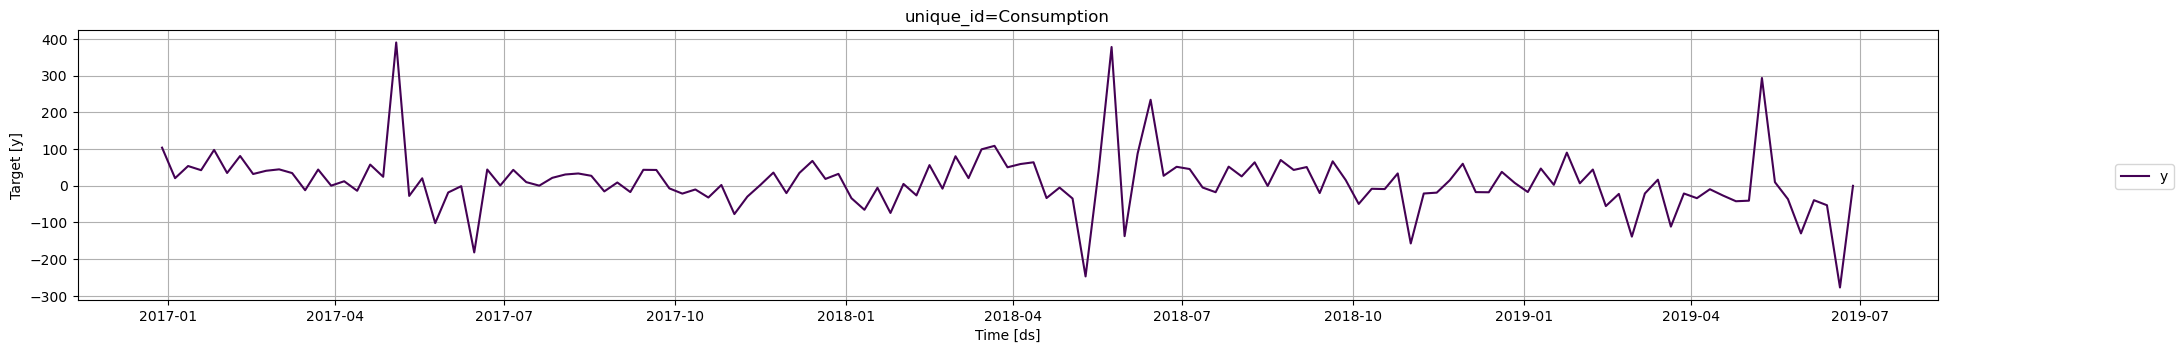

In [140]:
plot_series(prep)

Полученная таблица может быть исследована классическими методами машинного обучения. Например посмотрим на корреляцию признаков.

In [141]:
prep.drop(columns=['unique_id', 'ds']).corr()['y']

y        1.000000
lag1     0.077628
lag2     0.043126
lag52   -0.336049
Name: y, dtype: float64

Поcмотрим на результат нашего предсказания.
> Отметим, что для отображения цветовых палитр используется [matplotlib  colormap](https://matplotlib.org/stable/gallery/color/colormap_reference.html), который передается в виде аргумента `palette`.

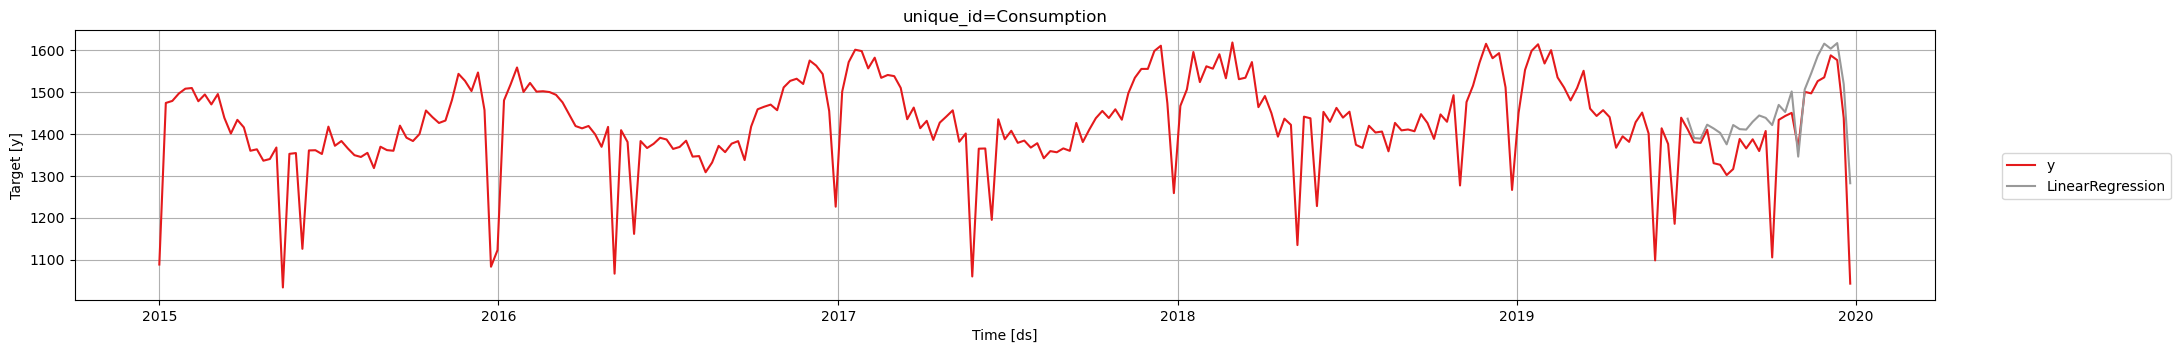

In [142]:
preds = fcst.predict(h = FH)
plot_series(df, preds, palette ='Set1')


Попробуем провести предсказание модели. Посмотрим на возможности `LinearRegression()` для решения этой задаичи. 

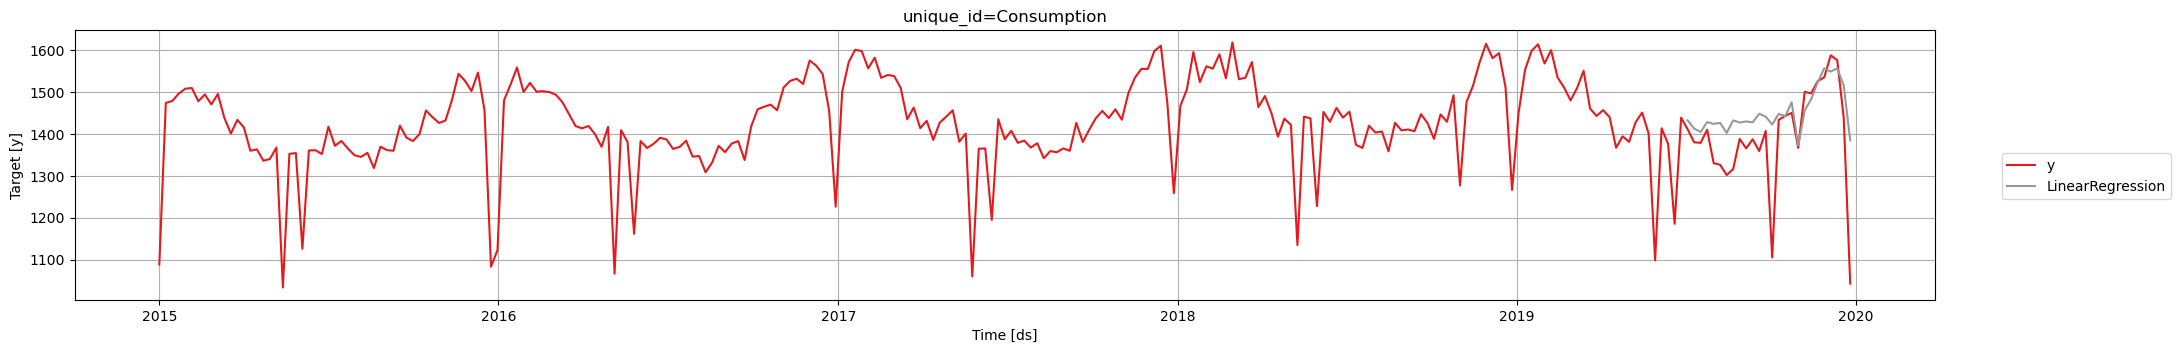

In [143]:
fcst = MLForecast(
    models=LinearRegression(),
    freq=FREQ,  # our serie has a monthly frequency
    lags=[1,2,52],
    target_transforms=None,
)
fcst.fit(df_train)
preds = fcst.predict(h = FH)
plot_series(df, preds, palette ='Set1')

Проведем оценку точности при помощи встроенных методов `rmse` и `smape` из библиотеки [utilsforecast](https://nixtlaverse.nixtla.io/utilsforecast/losses.html) 

In [144]:
from utilsforecast.losses import rmse, smape

In [145]:
preds['y'] = df_test['y'].values
cv_rmse  = rmse(preds,  models =['LinearRegression'], id_col='unique_id')
cv_smape = smape(preds, models =['LinearRegression'], id_col='unique_id')
cv_rmse['LinearRegression'].values, cv_smape['LinearRegression'].values

(array([105.73824093]), array([0.02441317]))

Отметим, что в целом результаты предсказаний могут быть оценены и другими способами. Выбор [метрик](https://permetrics.readthedocs.io/en/latest/pages/regression.html) очень важен, и нужно подходить к нему отвественно. 

In [146]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(preds['y'], preds['LinearRegression'])

0.052666151616115556

In [147]:
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError 
smape_ = MeanAbsolutePercentageError(symmetric = True)
rmse_  = MeanSquaredError(square_root=True)
smape_(preds['y'].values, preds['LinearRegression'].values),\
     rmse_(preds['y'].values, preds['LinearRegression'].values)

(0.048826332190265526, 105.73824092756551)

<span style="font-size:1.2em;">
    
>__Заметим__, что <tt>[SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)</tt> в фреймворке [`mlforecast/utilsforecast`](https://nixtlaverse.nixtla.io/utilsforecast/losses.html#symmetric-mean-absolute-percentage-error) считается в два раза ниже, чем в [`sktime`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsolutePercentageError.html#meanabsolutepercentageerror) (в `sktime` [правильней](https://otexts.com/fpp3/accuracy.html#percentage-errors)!).

## Работа с признаками

Важными особенностями фреймворка [<tt>mlforecast</tt>](https://nixtlaverse.nixtla.io/mlforecast/index.html) является возможность гибкого создания пайплайнов обработки признаков в объектах `MLForecast`. Для этого используются преобразованиями вида `target_transforms`, `lags`, `lag_transforms` и `date_features`. Все эти функции применяются к выбранным данным для формирования признаков выходной таблицы:
* __`target_transforms`__ - [преобразования меток](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/target_transforms_guide.html), которые уже рассматривались. В данном случае это будет их дифференцирование. Преобразования могут быть получены из модуля `mlforecast.target_transforms` или [описаны самостоятельно](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/target_transforms_guide.html#custom-transformations). Также могут быть использованы стандартные преобразования пакета `sklearn` если они требуют обучения. Например, логорифмирование. Для этого используется wrapper [`GlobalSklearnTransformer`](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/target_transforms_guide.html#globalsklearntransformer) 
* __`lags`__: используем $1, 2, 3, 52$-й, лаги, которые передаются в виде списка. Отметим, что потенциально вы можете передать диапазон `range` вместо листа.
* __`date_features`__: укажем на возможно нужные нам временные интервалы, это может быть дополнительной информацией.Для использования функций  необходимо убедиться, что столбец времени состоит из временных меток. Это можно сделать, передав список строк с компонентами [`pandas time/date components`](https://pandas.pydata.org/docs/user_guide/timeseries.html). Вы также можете передавать [самостоятельно сформированные функции, которые будут принимать столбец времени в качестве входных данных](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/custom_date_features.html). Функционал для этого может быть сформирован [специальными средствами Pandas](https://pandas.pydata.org/docs/user_guide/timeseries.html) или могут быть функции, созданные при [помощи сторонних утилит](https://khuyentran1401.github.io/Efficient_Python_tricks_and_tools_for_data_scientists/Chapter5/time_series.html), например создающие признаки [выходных дней](https://python-holidays.readthedocs.io/en/latest/). Мы создадим [функцию создающую признак конец года](https://pandas.pydata.org/pandas-docs/stable/reference/offset_frequency.html)  как пример.
* __`lag_transforms`__ определяются как словарь, в котором ключами являются запаздывания, а значениями - [списки преобразований](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/lag_transforms_guide.html), которые мы хотим применить к этому запаздыванию.  Преобрзования могут быть получены из стандартных модуля `mlforecast.lag_transforms`, либо функциями [`numba` `jitted`](https://numba.pydata.org/) (чтобы вычисление функций не стало узким местом и мы могли обойти `GIL` при использовании многопоточности). В том числе мы попробуем подходящую для такой демонстрации утилиту [`window_ops`](https://jmoralez.github.io/window_ops), ускоряющую стандартный [оконный функионал Pandas](https://pandas.pydata.org/docs/user_guide/window.html). Отметим, что преобразования могут комбинироваться при помощи класса [`Combine`](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/lag_transforms_guide.html#extending-the-built-in-transformations).

Отдельно укажем на возможность включения в пайплайны <tt>[экзогенных признаков](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/exogenous_features.html)</tt>. 
> [Важно указать](https://forecastegy.com/posts/multivariate-time-series-forecasting-in-python/), что при построение таблиц признаков с экзогенными факторами во временных рядах следует разделять 
>* Динамические признаки - это те, которые изменяются со временем и будут известны в будущем.
>* Cтатические признаки - те, что е меняются со временем.
> Например, значение `date_features` будет определенно известно в будущем, в тоже время значение, например, температуры вероятно не будет известно.  Для таких случаев в `MLForecast` будет повторять первое значение каждого статического признака для всех временных отметок, которые вы хотите предсказать. \

>В целом [при формировании признаков](https://netman.aiops.org/~peidan/ANM2019/5.KPIAnomalyDetection/ReadingLists/time_series.pdf) важно также понимать, что при слишьком большом признковом пространстве модели могут диградировать. [Особенно когда тренировочная выборка не большая](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-023-00727-2). То есть если нехватает данных.  Таким образом при выборе [пространств признаков](https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/) должны быть использованы и [методы отбора признаков](https://scikit-learn.org/stable/modules/feature_selection.html). Как миниму признаки должны [проверяться на корреляционные зависимости](https://www.researchgate.net/publication/272668319_Feature_Selection_for_Time_Series_Modeling).  



In [148]:
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from numba import njit
from window_ops.rolling import rolling_max, rolling_mean, rolling_min
import holidays

@njit
def rolling52(x):
    return rolling_mean(x, window_size=52)

Допустим, что мы хотели бы создать признаки данных. По существу это дискретные признаки, котроые могли бы быть рассмотрены как категориальные. Для таких признаков требуется кодирование, если речь не идет о бинарных признаках. Одним из способов кодирования являтся т.н. [`target encoding`](https://mlcourse.ai/book/topic09/topic9_part1_time_series_python.html#target-encoding). Попробуем задать такого кодирование для месецев каждого года.  Для этого создадим словарь, где каждому месяцу тренировочных данных будет присвоено среднее в нем значение.

In [149]:
y_ = df_.iloc[:-FH].Consumption.asfreq('M')
encoder = {month : y_[y_.index.month==month].mean() for month in range(1,13)}

Создадим также функционал для кодирования начала или конца года, выходных и обычных дней, `target` кодирования месяцев

In [150]:
def year_start_or_end(dates):
    return [1*(date_.week==1)+1*(date_.week==52) for date_ in dates]

def year_holidays(dates):
    return [1*(date_ in holidays.RUS()) for date_ in dates]

def month_(dates):
    return [encoder[date_.month] for date_ in dates]

Теперь непосредственно зададим параметры модели.

In [151]:
target_transforms = [Differences([52])]
lags = [1,52]
date_features  = ['quarter', month_, year_start_or_end, year_holidays]
lag_transforms = {  
        1: [ExpandingMean(), (rolling_max,  7)],
        52: [rolling52],
    }

И создадим объект для работы с ВР

In [152]:
fcst = MLForecast(
    models=[LinearRegression()],
    lags = lags,
    freq=FREQ,
    target_transforms=target_transforms,  
    date_features = date_features,
    lag_transforms=lag_transforms,
)
prep = fcst.preprocess(df)
prep.head(3)

,unique_id,y,ds,lag1,lag52,expanding_mean_lag1,rolling_max_lag1_window_size7,rolling52_lag52,quarter,month_,year_start_or_end,year_holidays
155,Consumption,18.622,2017-12-21,67.693,372.046,23.056981,67.693,26.432750,4,1119.88275,0,0
156,Consumption,32.381,2017-12-28,18.622,103.801,23.014337,67.693,27.767096,4,1119.88275,1,0
157,Consumption,-33.882,2018-01-04,32.381,20.676,23.103543,67.693,28.044750,1,1424.80320,1,1


In [153]:
prep['year_start_or_end'].values

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

Прежде чем переходить к дальнейшим рассуждениям попробуем провести [анализ признаков](https://mlcourse.ai/book/topic09/topic9_part1_time_series_python.html#regularization-and-feature-selection). Для начала посмотрим на визуализацию их корреляций.

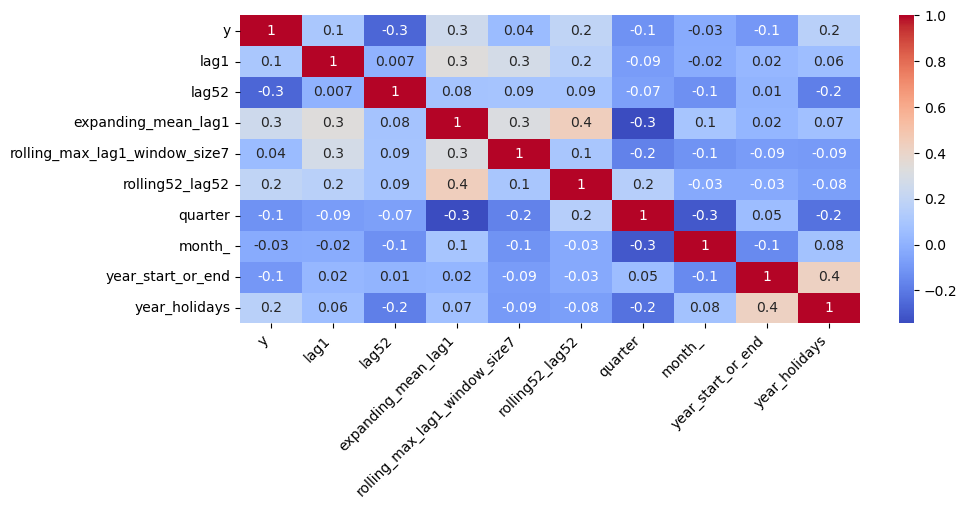

In [154]:
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.heatmap(prep.drop(columns=['unique_id','ds']).corr(), annot=True, fmt='.1g', cmap="coolwarm");
plt.xticks(rotation=45, ha='right')
plt.show()


Анализ показывает отсутсвие значительных корреляций для признаков.  В ином случае какие то из признаков пришлось бы удалять.

## Обучение модели `MLForecast`

Перейдем к исползованию `MLForecast` для предсказания. По умолчанию в `MLForecast` используется [рекурсивный ( авторегрессионный метод)](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/one_model_per_horizon.html). Этот метод предполагает предсказания горизонта [по одному шагу за раз](https://forecastegy.com/posts/multiple-time-series-forecasting-with-scikit-learn/#recursive-vs-direct-forecasting).

Для обучения моделей, сформированных преобразованиями используется метод `MLForecast.fit`. Для этого метода задаются модели  в параметре `models`. Модели могут быть заданы:
* в виде списка (в котором они будут названы с помощью имени класса и индекса, если классы повторяются) 
* в виде словаря, где ключи - это имена, которые вы хотите дать моделям, то есть имя столбца, в котором будут храниться их предсказания. 
Попробуем обучить несколько моделей 
<!-- одного класса `LightGradientBoosting`. -->





<!-- <quote>
Напомним, что существует как минимум 3 различных способа построения прогнозов при использовании машинного обучения для временных рядов.

Чтобы понять этот метод, представьте временной ряд, содержащий всего 10 наблюдений, и модель, обученную прогнозировать только на 1 шаг вперед.

Чтобы получить прогнозы на несколько периодов, мы добавим предсказание следующего шага в исходный ряд, как если бы это была новая выборка, и используем модель для прогнозирования следующего периода.

Мы повторяем эти шаги для следующих периодов, пока не получим прогнозы на весь горизонт, который хотим предсказать. -->
Рекурсивный метод быстрее остальные в обучении, особенно если у вас большой горизонт прогнозирования. Однако, в качестве альтернативы [можно использовать прямой метод](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/one_model_per_horizon.html), при котором для каждого шага горизонта прогнозирования строится отдельная, индивидуальная модель. Чтобы использовать прямой метод в `MLForecast`, просто передайте аргумент `max_horizon` в методе `fit` с количеством периодов, которые вы хотите предсказать.
>Важно понимать, что без тестирования невозможно определить, какой метод лучше, поэтому, если вам нужна наилучшая производительность, даже если вычислительные затраты высоки, тестируйте оба метода.

<!-- Таким образом, если мы хотим предсказать 10 периодов, мы обучаем 10 моделей, каждая из которых будет предсказывать определенный шаг.
 -->




 

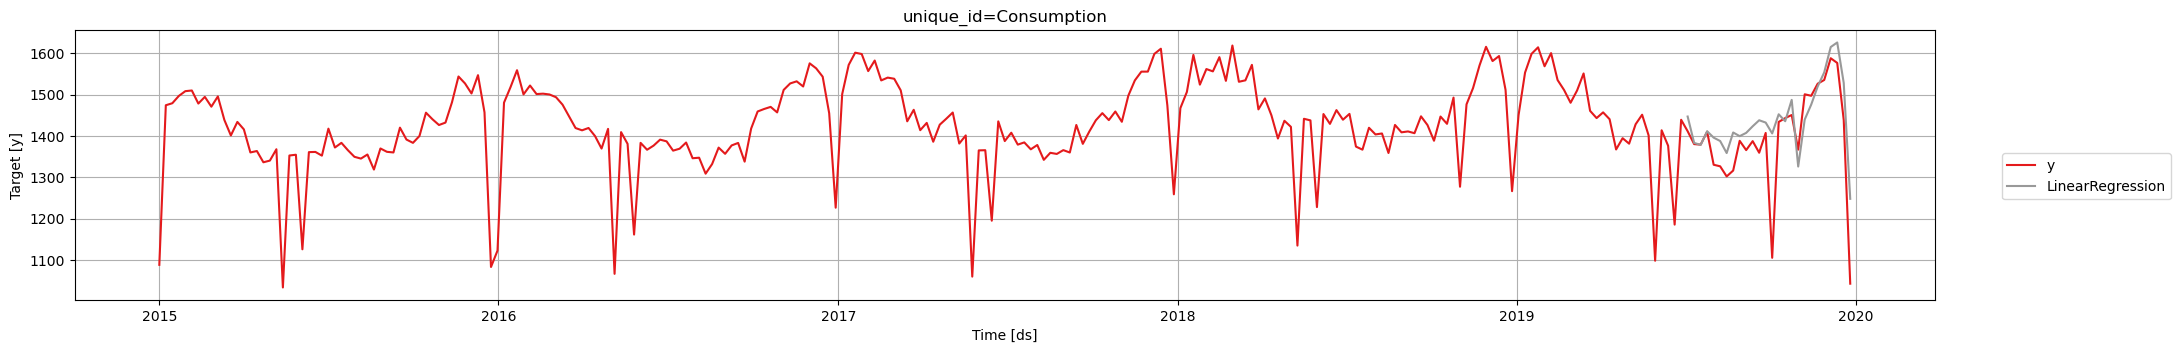

In [155]:
fcst.fit(df_train)
preds = fcst.predict(FH)
plot_series(df, preds,palette ='Set1')

In [156]:
preds['y'] = df_test['y'].values
cv_rmse  = rmse(preds, models=['LinearRegression'], id_col='unique_id')
cv_smape = smape(preds, models=['LinearRegression'], id_col='unique_id')
pd.concat([cv_rmse,cv_smape])

,unique_id,LinearRegression
0,Consumption,83.858279
0,Consumption,0.020031


Полезной особенностью фреймворка может быть очень простой способ сравнения моделей. Как уже говорилось модели могут быть заданы при помощи словаря, как это показано ниже.

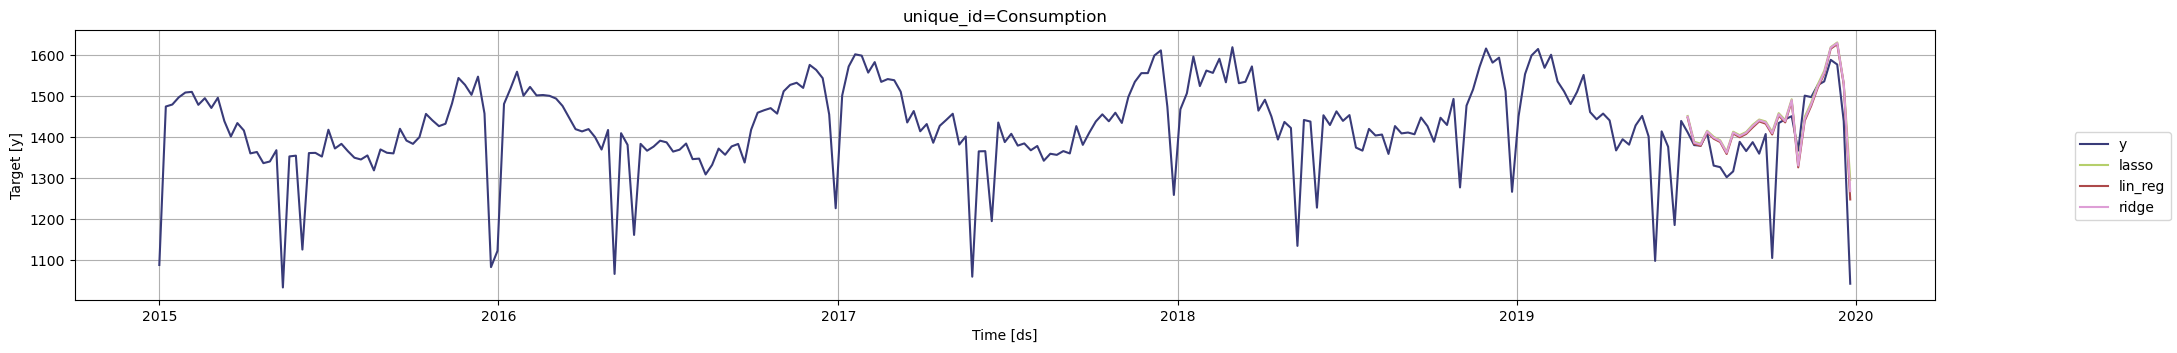

In [157]:
models={
        'lasso': Lasso(),
        'lin_reg': LinearRegression(),
        'ridge': Ridge(),
}


fcst = MLForecast(
    models=models,
    lags = lags,
    freq=FREQ,
    target_transforms=target_transforms,  
    date_features = date_features,
    lag_transforms=lag_transforms,
)
fcst.fit(df_train)
preds = fcst.predict(FH)
plot_series(df, preds, palette='tab20b')

Напоминим, что мы можем достать обученные модели из объекта как аргумент `models_` 

In [158]:
preds['y'] = df_test['y'].values
smape(preds, models= list(fcst.models_.keys()), id_col='unique_id')

,unique_id,lasso,lin_reg,ridge
0,Consumption,0.021554,0.020031,0.020818


Сравним результаты, полученные при помощи рекурсивного метода с теми, которые мы могли бы получить [в "прямом" проходе](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/one_model_per_horizon.html). Для Этого зададим парамерт `max_horizon`. В нашем случае этот метод работает немного хуже.

In [159]:
max_horizon = 26

individual_fcst = fcst.fit(df_train, max_horizon=max_horizon)
individual_preds = individual_fcst.predict(h = max_horizon)

individual_preds['y'] = df_test['y'].values[:max_horizon]
smape(individual_preds, models= list(fcst.models_.keys()), id_col='unique_id')

,unique_id,lasso,lin_reg,ridge
0,Consumption,0.025721,0.027424,0.026966


Отдельно отметим возможность обучения моделей в интерфейсе фреймворка `sklearn` при помощи метода [`fit_models`](https://nixtlaverse.nixtla.io/mlforecast/forecast.html#mlforecast-fit-models). Для этого сформируем необходимые таблицы. Отметим, что в данном случае мы воспользуемся особым режимом метода  `preprocess` который задается аргументом `return_X_y=True`. В этом режиме он вернет два массива `X` - таблицу признаков и `y` - результат работы. Режим эквивалентен следующему коду
```python 
    prep = fcst.preprocess(df_train)
    X = prep.drop(columns=['unique_id', 'ds', 'y'])
    y = prep['y']
```

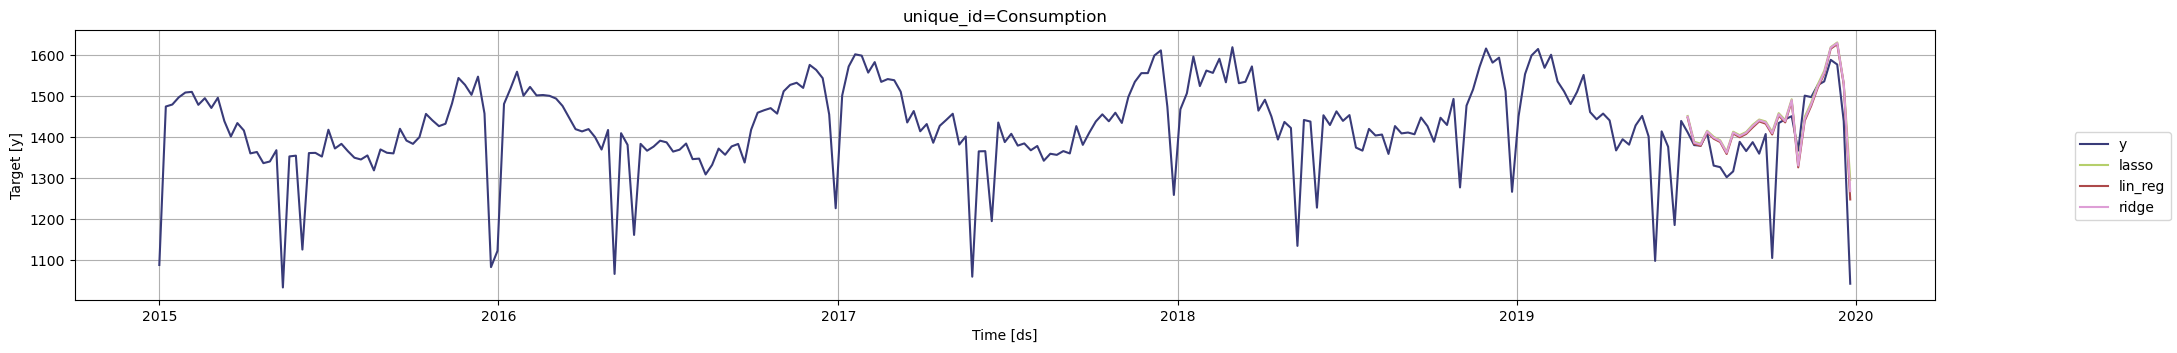

In [160]:
X, y = fcst.preprocess(df_train, return_X_y=True, as_numpy=True)

fcst.fit_models(X, y)
preds = fcst.predict(FH)
plot_series(df, preds, palette='tab20b')

Также каждая из моделей может быть обучена отдельно, при помощи обращения к ней.

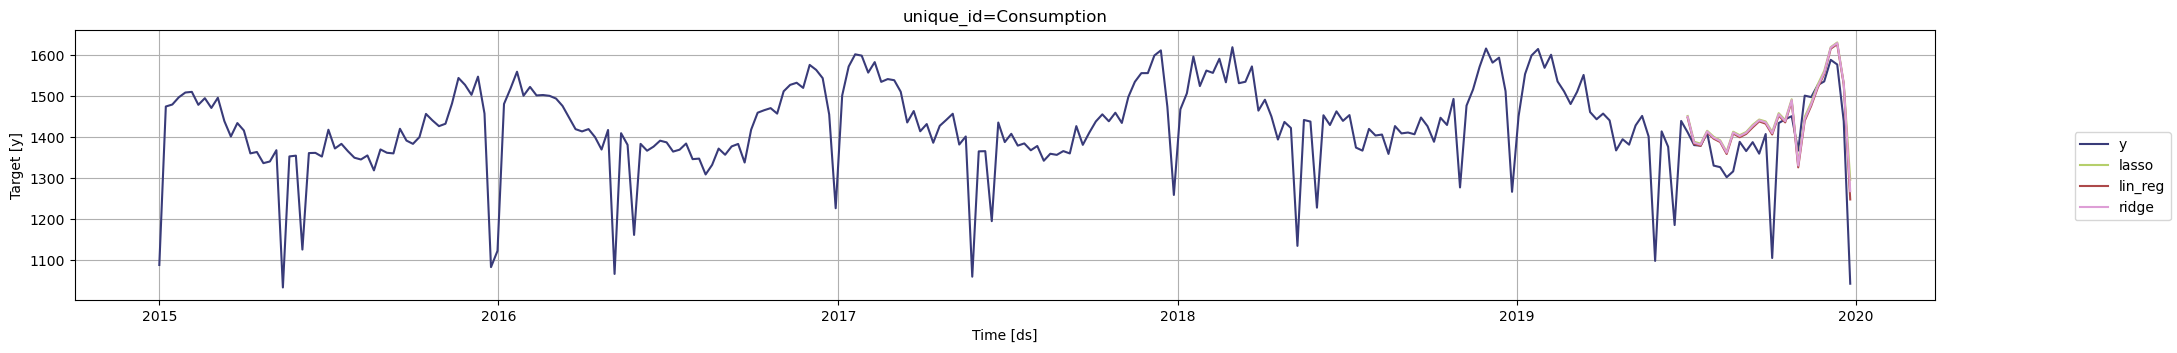

In [161]:
fcst.models_['lin_reg'].fit(X, y)
preds = fcst.predict(FH)
plot_series(df, preds, palette='tab20b')

Также [можно добавить](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/custom_training.html#custom-training) новую модель, имеющую интерфейс `sklearn` к существуюим. 
>Однако тут нужно быть очень аккуратным. Модель действует в фреймворке сформированной таблицы признаков!
>Это имеет свои плюсы - пред и постпроцессинг гарантируются без ошибок. Но модель должна ожидаемо реагировть на признаки. В том числе стоит понимать, что модель должна обучаться на данных, для которых предусмотрен тест.

> Также ометмим, что предсказатели могут быть реализованы самостоятельно при помощи, например, следующего кода: 
```python
from sklearn.base import BaseEstimator

 class Naive(BaseEstimator):
     def fit(self, X, y):
         return self

     def predict(self, X):
         return X['lag1'] 
```

In [162]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(verbosity=-1).fit(X, y)
fcst.models_['lgb'] = lgb
print(fcst.models_)
preds = fcst.predict(FH)
preds['y'] = df_test['y'].values
smape(preds, models= list(fcst.models_.keys()), id_col='unique_id')

{'lasso': Lasso(), 'lin_reg': LinearRegression(), 'ridge': Ridge(), 'lgb': LGBMRegressor(verbosity=-1)}


,unique_id,lasso,lin_reg,ridge,lgb
0,Consumption,0.021554,0.020031,0.020818,0.029998


По мимо размещения моделей предсказания как таковых могут быть созданы [пайплайны предсказания](https://forecastegy.com/posts/multivariate-time-series-forecasting-in-python/). Создадим такой пайплайн с использованием стандартизации признаков и их отбора методом PCA.

In [163]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

models = {'pca_lasso': make_pipeline (StandardScaler(),
                                      PCA(n_components=5), 
                                      Lasso()),
         'lin_reg': LinearRegression()}

fcst = MLForecast(
    models=models,
    lags = lags,
    freq=FREQ,
    target_transforms=target_transforms,  
    date_features = date_features,
    lag_transforms=lag_transforms,
)
fcst.fit(df_train)
preds = fcst.predict(FH)
preds['y'] = df_test['y'].values
smape(preds, models= list(fcst.models_.keys()), id_col='unique_id')

,unique_id,pca_lasso,lin_reg
0,Consumption,0.020407,0.020031


Также отметим, что для категориальных признаков важно бы было их кодирование. В нескотором смысле признаки дат можно считать категориальными.  Мы уже увидили, что иногда можно заменять такие призаких их т.н. [`target encoding`](https://letsdatascience.com/target-encoding/). В нелинейных можно бы было оставить признак квартал год без изменений - фактически используя [Label encoding](https://scikit-learn.org/stable/modules/preprocessing_targets.html). Однако в линейных моделях его рекомендуется кодировать. Так как модели чувствительны к значениям. Покажем как можно кодировать такие признаки при помощи  [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). Для этого также [задействуем `ColumnTransformer` из библиотеки `sklearn`](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/sklearn_pipelines.html).

In [164]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ohe = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(drop='first'), ['quarter'])
    ],
    remainder='passthrough',
)


models = {'pca_lasso': make_pipeline (StandardScaler(),
                                      PCA(n_components=5), 
                                      Lasso()),
          'ohe_lasso': make_pipeline (ohe,
                                      StandardScaler(),
                                      PCA(n_components=5),
                                      Lasso()),          
         'lin_reg': LinearRegression()}

fcst = MLForecast(
    models=models,
    lags = lags,
    freq=FREQ,
    target_transforms=target_transforms,  
    date_features = date_features,
    lag_transforms=lag_transforms,
)
fcst.fit(df_train)
preds = fcst.predict(FH)
preds['y'] = df_test['y'].values
smape(preds, models= list(fcst.models_.keys()), id_col='unique_id')

,unique_id,pca_lasso,ohe_lasso,lin_reg
0,Consumption,0.020407,0.017478,0.020031


Помимо оценки точности обученных моделей мы можем проинспектировать их более детально. Например рассмотрим весовые коэффициенты линейной модели. Или важность признаков. Для них мы получим имена, чтобы лучше отобразить на графике. Отметим, что мы получим имена особым аргументом, эквивалентным следующей записи
```python
fcst.preprocess(df).drop(columns=['unique_id','ds','y']).columns.to_list()
```


In [165]:
from sklearn.inspection import permutation_importance

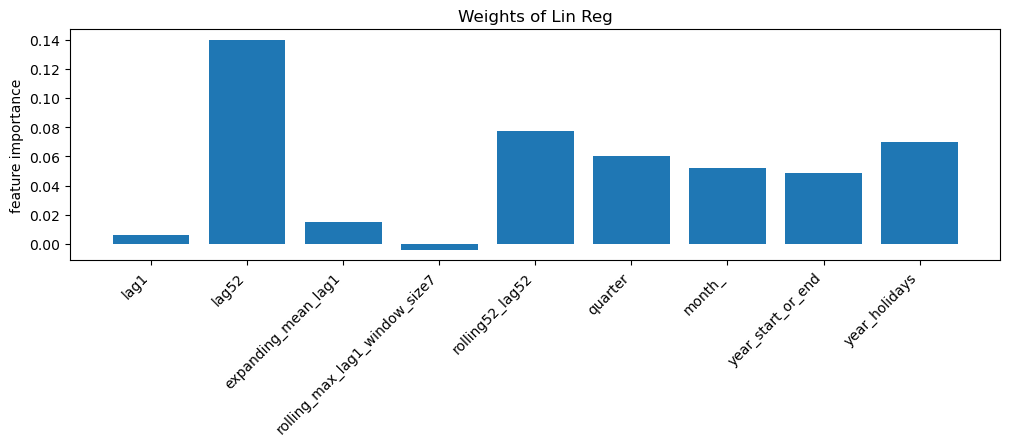

In [166]:
X, y = fcst.preprocess(df, return_X_y=True, as_numpy=True)

X_train, y_train,  X_test, y_tset = X[:-FH,:], y[:-FH], X[FH:,:], y[FH:]
feature_names = fcst.ts.features_order_

fcst.models_['lin_reg'].fit(X_train, y_train)

result = permutation_importance(fcst.models_['lin_reg'], X_test, y_tset, n_repeats=30, random_state=42)
perm_importances = result.importances_mean
# perm_std = result.importances_std


plt.figure(figsize=(12,3))
plt.bar(feature_names, perm_importances)
plt.ylabel('feature importance')
plt.title('Weights of Lin Reg')
plt.xticks(rotation=45, ha='right')
plt.show()

Наибольшее значение имеет лаг 52, а также то, выходной день или нет. В некоторым смысле это ожидаемые результаты.

Также можно произвести анализ общими фреймворками

In [167]:
import shap

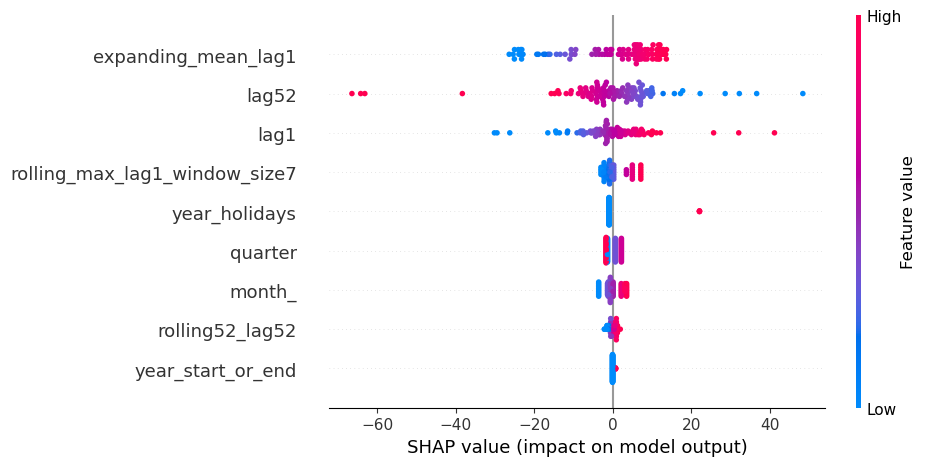

In [168]:
prep = fcst.preprocess(df)
X = prep.drop(columns=['unique_id', 'ds', 'y'])
X100 = shap.utils.sample(X, 100)

explainer = shap.Explainer(fcst.models_['ohe_lasso'].predict, X100)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)

Также видим, что значения лага 52 важны. Но почему-то важен и лаг 1.

В конце раздела также скажем о возможности использования сторонней оптимизации для  поиска гиперпараметров моделей в рамках `mlforecast`. В данном [примере](https://forecastegy.com/posts/multiple-time-series-forecasting-with-lightgbm-in-python/) мы попробуем подобрать параметры модели  `Lasso` и последний лаг в объекте при помощи популярной библиотеки [`optuna`](https://optuna.org/). Для этого опишим объект оптимизации и т.н. [`trail`](https://github.com/optuna/optuna/blob/master/README.md#key-features) для оптимизируемых параметров. 

In [169]:
import optuna

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-3, 1e-0, step=1e-3)
    selection = trial.suggest_categorical('selection ', ['cyclic', 'random'])
    
    last_lag = trial.suggest_int('llag', 13, 52, step=13)

    models = [Lasso(alpha=alpha,selection=selection) ]
    
    model = MLForecast(
                    models=models,
                    freq=FREQ,
                    lags=[1,2, last_lag],
                    target_transforms=target_transforms,
                    date_features = date_features,
                    lag_transforms={1: [(rolling_max, 7)]},
                    num_threads=6)


    model.fit(df_train, id_col='unique_id', time_col='ds', target_col='y')

    preds = model.predict(FH)
    
    preds = preds.merge(df_test[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

    error = mean_absolute_percentage_error(preds['y'], preds['Lasso'])
    
    return error


# plot_series(df, preds, palette='tab20b')

Теперь создадим процесс оптимизации и запустим его. После чего посмотрим на лучшие результаты.

In [170]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
study.best_params

[I 2024-04-11 19:22:55,708] A new study created in memory with name: no-name-da978ec6-1ccf-45c4-8b96-32696892dea2
[I 2024-04-11 19:22:56,003] Trial 0 finished with value: 0.051118170927468384 and parameters: {'alpha': 0.87, 'selection ': 'cyclic', 'llag': 52}. Best is trial 0 with value: 0.051118170927468384.
[I 2024-04-11 19:22:56,253] Trial 1 finished with value: 0.05797412470766077 and parameters: {'alpha': 0.811, 'selection ': 'random', 'llag': 26}. Best is trial 0 with value: 0.051118170927468384.
[I 2024-04-11 19:22:56,497] Trial 2 finished with value: 0.0554520846008223 and parameters: {'alpha': 0.2, 'selection ': 'cyclic', 'llag': 13}. Best is trial 0 with value: 0.051118170927468384.
[I 2024-04-11 19:22:56,732] Trial 3 finished with value: 0.06047221714506808 and parameters: {'alpha': 0.754, 'selection ': 'cyclic', 'llag': 39}. Best is trial 0 with value: 0.051118170927468384.
[I 2024-04-11 19:22:56,974] Trial 4 finished with value: 0.05737709869269218 and parameters: {'alpha'

{'alpha': 0.87, 'selection ': 'cyclic', 'llag': 52}

In [171]:
models={'lasso': Lasso(alpha= 0.467, selection='cyclic'),}

fcst = MLForecast(
    models=models,
    lags = lags,
    freq=FREQ,
    target_transforms=target_transforms,  
    date_features = date_features,
    lag_transforms=lag_transforms,
)
fcst.fit(df_train)
preds = fcst.predict(FH)
preds['y'] = df_test['y'].values
smape(preds, models= list(fcst.models_.keys()), id_col='unique_id')

,unique_id,lasso
0,Consumption,0.020732


## Валидация ML моделей

<!-- >Отметим, что если необходимо определить, почему модель выдала определенное предсказание, то значения входных признаков для отедльных предсказаний могут быть определены при помощи специального колл-бека `SaveFeatures` в  следующем виде
from mlforecast.callbacks import SaveFeatures
save_feats = SaveFeatures()
preds = fcst.predict(1, before_predict_callback=save_feats)
features = save_feats.get_features()
features
shap_values_predictions = explainer(features)
# shap_values_predictions
shap.plots.waterfall(shap_values_predictions) -->

Теперь мы используем метод [`cross_validation`](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/cross_validation.html) для обучения и оценки моделей. В данном случае это будет аналог `ExtendedWindowCV` рассмотренного ранее. Здадим следующие парамерты:
* `df`: Получает обучающие данные 
* `h`: Горизонт прогнозирования 
* `n_windows`: Количество складок, которые мы хотим спрогнозировать.

Также можно задать имена столбцов временного ряда: 
+ `id_col`:Столбец, идентифицирующий каждый ВР (по умолчанию уникальный_ид) 
+ `time_col`: Столбец, идентифицирующий каждый временной шаг, его значения могут быть временными метками или целыми числами (По умолчанию `ds`) 
+ `target_col`:Столбец, содержащий целевой ВР (По умолчанию `y`)

Отметим что в полеченных результатах будут показаны:
* `cutoff`: последняя временная метка для каждого из `n_windows`.
* `models`: набор столбцов для моделей

> Напомним, что `ExtendedWindowCV` может быть [отображен как](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/cross_validation.html):
<img src="https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif" width="500px">

In [172]:
models = {'ridge': make_pipeline (StandardScaler(),Ridge()),
          'lasso': make_pipeline (StandardScaler(),Lasso()),          
          'lin_reg':   make_pipeline (StandardScaler(),LinearRegression())}

fcst = MLForecast(
    models=models,
    lags = lags,
    freq=FREQ,
    target_transforms=target_transforms,  
    date_features = date_features,
    lag_transforms=lag_transforms,
)
fcst.fit(df_train)

MLForecast(models=[ridge, lasso, lin_reg], freq=<7 * Days>, lag_features=['lag1', 'lag52', 'expanding_mean_lag1', 'rolling_max_lag1_window_size7', 'rolling52_lag52'], date_features=['quarter', <function month_ at 0x000001AE163B1800>, <function year_start_or_end at 0x000001AE163B1BC0>, <function year_holidays at 0x000001AE163B1940>], num_threads=1)

In [173]:
cv_df = fcst.cross_validation(
    df=df,
    h=26,
    n_windows=4,
    refit=True,
    id_col = 'unique_id',
    time_col = 'ds',
    target_col = 'y',
)
cv_df.head(4)

,unique_id,ds,cutoff,y,ridge,lasso,lin_reg
0,Consumption,2018-01-04,2017-12-28,1467.407,1528.405794,1529.372898,1528.567324
1,Consumption,2018-01-11,2017-12-28,1506.485,1594.796027,1601.018623,1594.427588
2,Consumption,2018-01-18,2017-12-28,1596.151,1624.191330,1630.421868,1624.050257
3,Consumption,2018-01-25,2017-12-28,1524.241,1624.496315,1627.210998,1624.783126


In [174]:
cv_df['cutoff'].unique()

<DatetimeArray>
['2017-12-28 00:00:00', '2018-06-28 00:00:00', '2018-12-27 00:00:00',
 '2019-06-27 00:00:00']
Length: 4, dtype: datetime64[ns]

Попробуем визуализировать результаты

In [175]:
def plot_cv(df, df_cv, uid, last_n=26*4):
    cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    fig, ax = plt.subplots(nrows=len(cutoffs), ncols=1, figsize=(14, 6), gridspec_kw=dict(hspace=0.8))
    
    for cutoff, axi in zip(cutoffs, ax.flat):
        df.query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax=axi, title=uid, y='y')
        df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').drop(['cutoff'], axis=1).plot(ax=axi, title=uid)
#     fig.savefig(fname, bbox_inches='tight')
    plt.show()

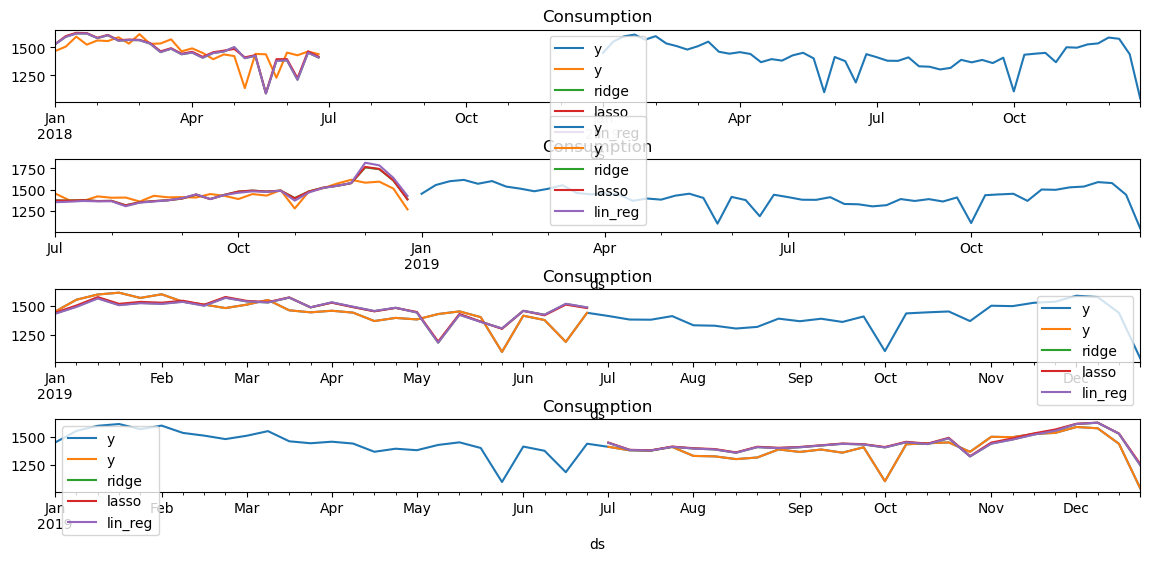

In [176]:
plot_cv(df, cv_df, 'Consumption', last_n=26*2)

Визуальный просмотр прогнозов может дать нам некоторое представление о том, как ведет себя модель, но для того, чтобы оценить ее работу, нам необходимо оценить ее с помощью метрик. Для этого мы используем библиотеку [`utilsforecast`](https://nixtla.github.io/utilsforecast/), которая содержит множество полезных метрик и функцию `evaluate`.

In [177]:
from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

In [178]:
# Metrics to be used for evaluation
metrics = [
    mae,
    rmse,
    mape,
    smape
]

In [179]:
# Function to evaluate the crossvalidation
def evaluate_cv(crossvalidation_df, metrics, models):
    evaluations = []
    for c in crossvalidation_df['cutoff'].unique():
        df_cv = crossvalidation_df.query('cutoff == @c')
        evaluation = evaluate(
            df = df_cv,
            metrics=metrics,
            models=list(models.keys())
            )
        evaluations.append(evaluation)
    evaluations = pd.concat(evaluations, ignore_index=True).drop(columns='unique_id')
    evaluations = evaluations.groupby('metric').mean()
    return evaluations.style.background_gradient(cmap='RdYlGn_r', axis=1)

In [180]:
evaluate_cv(cv_df, metrics, models)

,ridge,lasso,lin_reg
metric,,,
mae,65.562773,64.963236,67.524108
mape,0.047976,0.047628,0.049267
rmse,93.913010,93.808807,97.358673
smape,0.023480,0.023251,0.024093


Функция [`PredictionIntervals`](https://nixtlaverse.nixtla.io/mlforecast/utils.html#predictionintervals) используется для вычисления интервалов предсказания для моделей, использующих т.н. [конформное предсказание интервалов](https://nixtlaverse.nixtla.io/mlforecast/docs/tutorials/prediction_intervals_in_forecasting_models.html#conformal-prediction). Функция принимает следующие аргументы: 
+ n_windows: количество окон кросс-валидации, используемых для калибровки интервалов 
+ h: горизонт прогнозирования

In [181]:
from mlforecast.utils import PredictionIntervals

In [182]:
fcst = MLForecast(
    models = models,
    lags = lags,
    freq=FREQ,
    target_transforms= target_transforms,  
    date_features    = date_features,
    lag_transforms   = lag_transforms,
)
fcst.fit(df_train, 
        prediction_intervals=PredictionIntervals(n_windows=2, h=26));

При использовании вертоятностных мер в обучении допускается задание интервалов прогнозирования по уровням. Мы укажем уровни $[90,95]$.

In [183]:
levels = [90, 95] # Levels for prediction intervals
pred = fcst.predict(h = 26, level=levels)
pred['y'] = df_test['y'].values[:26]
pred.head()

,unique_id,ds,ridge,lasso,lin_reg,ridge-lo-95,ridge-lo-90,ridge-hi-90,ridge-hi-95,lasso-lo-95,lasso-lo-90,lasso-hi-90,lasso-hi-95,lin_reg-lo-95,lin_reg-lo-90,lin_reg-hi-90,lin_reg-hi-95,y
0,Consumption,2019-07-04,1447.266358,1449.539432,1447.071126,1351.849882,1353.088893,1541.443823,1542.682834,1351.173469,1352.517241,1546.561623,1547.905394,1325.457544,1327.019839,1567.122413,1568.684708,1411.509
1,Consumption,2019-07-11,1383.205163,1385.126411,1383.238537,1360.097621,1361.565807,1404.844519,1406.312705,1361.441859,1362.951850,1407.300972,1408.810963,1346.606969,1348.169443,1418.307632,1419.870105,1380.383
2,Consumption,2019-07-18,1378.467325,1380.205819,1378.524124,1337.174274,1339.850854,1417.083796,1419.760376,1338.526748,1341.223145,1419.188494,1421.884891,1328.615587,1332.560879,1424.487368,1428.432661,1379.032
3,Consumption,2019-07-25,1411.647532,1413.865178,1411.410596,1358.721293,1361.121627,1462.173437,1464.573771,1361.380146,1363.805167,1463.925189,1466.350210,1356.223677,1359.409685,1463.411507,1466.597515,1410.417
4,Consumption,2019-08-01,1396.287253,1399.240133,1395.995129,1359.851467,1360.156017,1432.418489,1432.723039,1362.683532,1362.962134,1435.518132,1435.796734,1354.254238,1354.391034,1437.599224,1437.736020,1330.420


In [184]:
evaluate(
    df = pred,
    metrics=metrics,
    models=list(models.keys())
)

,unique_id,metric,ridge,lasso,lin_reg
0,Consumption,mae,53.523200,55.188354,53.518943
1,Consumption,rmse,83.938923,86.018584,83.858279
2,Consumption,mape,0.042399,0.043723,0.042379
3,Consumption,smape,0.020036,0.020625,0.020031


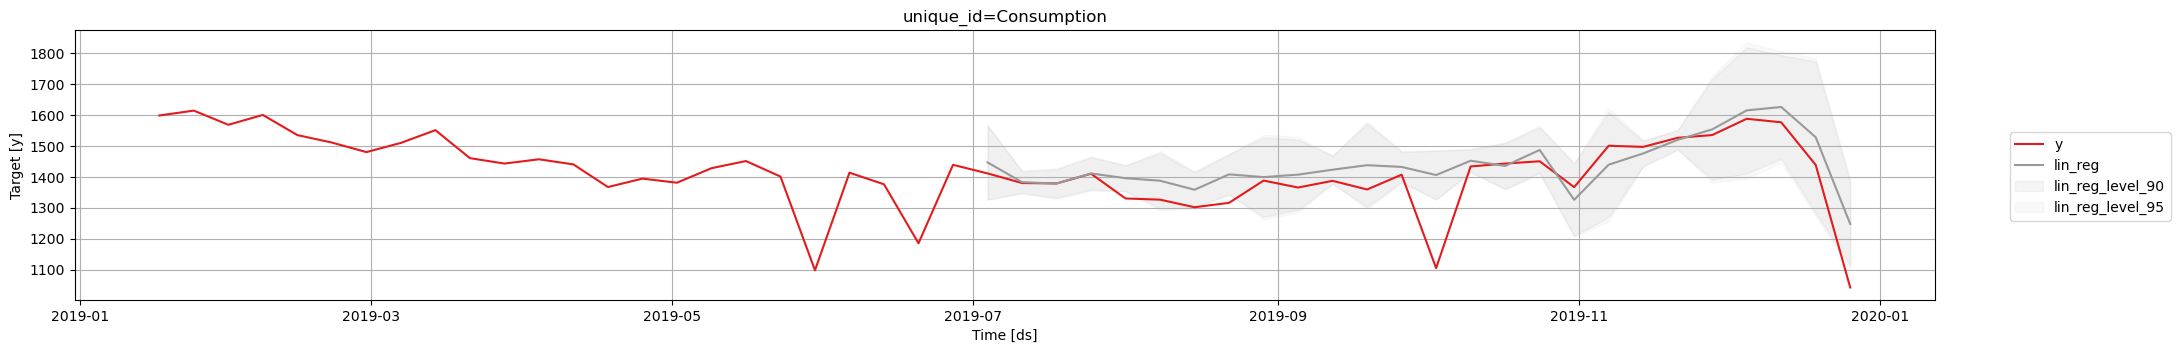

In [185]:
plot_series(
    df_train, 
    pred, 
    models=['lin_reg'],
    plot_random=False, 
    level=levels, 
    max_insample_length=24,
    palette='Set1'
)

Попробуем сравнить модель с внешним фреймворком `Prophet`

In [186]:
from prophet import Prophet


# create prophet model
prophet = Prophet(interval_width=0.9)
prophet.fit(df_train)

future = prophet.make_future_dataframe(periods=len(df_test), freq='7D', include_history=False)
forecast_prophet = prophet.predict(future)

# data wrangling
forecast_prophet = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_prophet.columns = ['ds', 'Prophet', 'Prophet-lo-90', 'Prophet-hi-90']
forecast_prophet.insert(0, 'unique_id', 'Consumption')
forecast_prophet.head()

19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing


,unique_id,ds,Prophet,Prophet-lo-90,Prophet-hi-90
0,Consumption,2019-07-04,1420.586501,1309.948346,1533.192534
1,Consumption,2019-07-11,1420.690282,1311.798511,1524.206990
2,Consumption,2019-07-18,1414.806370,1308.051121,1522.863659
3,Consumption,2019-07-25,1401.329858,1291.111315,1505.900771
4,Consumption,2019-08-01,1386.500201,1277.284284,1501.293230


In [187]:
# pred_ = pred.merge(pred, how='left', on=['unique_id', 'ds', 'y']).merge(
#     forecast_prophet, how='left', on=['unique_id', 'ds', 'y']).rename(columns={"y_y": "y"})
# pred_
pred['Prophet'] = forecast_prophet['Prophet'].values
pred['Prophet-lo-90'] = forecast_prophet['Prophet-lo-90'].values
pred['Prophet-hi-90'] = forecast_prophet['Prophet-lo-90'].values
pred.head(2)

,unique_id,ds,ridge,lasso,lin_reg,ridge-lo-95,ridge-lo-90,ridge-hi-90,ridge-hi-95,lasso-lo-95,...,lasso-hi-90,lasso-hi-95,lin_reg-lo-95,lin_reg-lo-90,lin_reg-hi-90,lin_reg-hi-95,y,Prophet,Prophet-lo-90,Prophet-hi-90
0,Consumption,2019-07-04,1447.266358,1449.539432,1447.071126,1351.849882,1353.088893,1541.443823,1542.682834,1351.173469,...,1546.561623,1547.905394,1325.457544,1327.019839,1567.122413,1568.684708,1411.509,1420.586501,1309.948346,1309.948346
1,Consumption,2019-07-11,1383.205163,1385.126411,1383.238537,1360.097621,1361.565807,1404.844519,1406.312705,1361.441859,...,1407.300972,1408.810963,1346.606969,1348.169443,1418.307632,1419.870105,1380.383,1420.690282,1311.798511,1311.798511


In [188]:
evaluate(
    df = pred,
    metrics=metrics,
    models=list(models.keys())+['Prophet'])

,unique_id,metric,ridge,lasso,lin_reg,Prophet
0,Consumption,mae,53.523200,55.188354,53.518943,59.656094
1,Consumption,rmse,83.938923,86.018584,83.858279,100.122985
2,Consumption,mape,0.042399,0.043723,0.042379,0.048044
3,Consumption,smape,0.020036,0.020625,0.020031,0.022269
